`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`mamba update cmip6_preprocessing -y`

In [1]:
import cmip6_preprocessing
cmip6_preprocessing.__version__

'0.5.1.dev1+g4ef7105'

In [2]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import merge_variables

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [4]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['dissic','talk', 'so', 'thetao']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'NorESM2-LM', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# variables = ['thetao', 'so', 'talk', 'dissic']
# z_kwargs = {'consolidated': True, 'use_cftime': True}
# query = dict(experiment_id=['historical'], table_id=['Omon'], 
#              variable_id=variables,
#              grid_label=['gr'],
#              source_id=['E3SM-1-0', 'E3SM-1-1', 'GFDL-ESM4',
#                         'CESM2-FV2','CESM2','MRI-ESM2-0',
#                         'CESM2-WACCM-FV2','GFDL-CM4','CESM2-WACCM',
#                         'E3SM-1-1-ECA'])


# cat = col.search(**query)

# dset_dict_old = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
#                                 preprocess=combined_preprocessing, aggregate=False)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
dd_new = merge_variables(dset_dict_old)
# dd_new

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2.historical.r10i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessi

In [6]:
temp={}
for name,item in dd_new.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new = temp
list(dd_new.keys())

['CESM2-WACCM.gr.historical.Omon.r3i1p1f1',
 'GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r6i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'NorESM2-LM.gr.historical.Omon.r1i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1',
 'CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1']

In [7]:
dd_new_new = combine_datasets(
    dd_new,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new.keys())

['CESM2-WACCM.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'NorESM2-LM.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

In [10]:
list(dd_new_new.keys())

['CESM2.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'NorESM2-LM.gr.historical.Omon']

### Error in aggregation for 3 models
> `'E3SM-1-1'`

> `'E3SM-1-0'`

> `'NorCPM1'`

`results = pyco2.sys(par1=None, par2=None, par1_type=None, par2_type=None, **kwargs)`

### Arguments

`par1` and `par2`: values of two different carbonate system parameters.

`par1_type` and `par2_type`: which types of parameter par1 and par2 are.


Total alkalinity (type `1`) in μmol·kg−1.
> <font color='red'>alkalinity in CMIP6 is in mol/m3 </font> 

Dissolved inorganic carbon (type `2`) in μmol·kg−1.
> <font color='red'>DIC in CMIP6 is in mol/m3 </font> 

pH (type `3`) on the Total, Seawater, Free or NBS scale1. Which scale is given by the argument opt_pH_scale.

Partial pressure of CO2 (type `4`) in μatm, Fugacity of CO2 (type `5`) in μatm, Aqueous CO2 (type `8`) in μmol·kg−1, or Dry mole fraction of CO2 (type `9`) in ppm.

Carbonate ion (type `6`) in μmol·kg−1.

Bicarbonate ion (type `7`) in μmol·kg−1.

### Kwargs/hydrographic conditions

`salinity`: practical salinity (dimensionless).

`temperature`: temperature at which `par1` and `par2` arguments are provided in °C (default 25 °C).
> <font color='red'>in situ temp </font> 
> `gsw.t_from_CT(SA, CT, p)`

`pressure`: water pressure at which `par1` and `par2` arguments are provided in dbar (default 0 dbar).
> pressure_in will be related to depth

> `gsw.p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)` = dbar

> > Parameters

> > > zarray-like: Depth, positive up, m

> > > latarray-like: Latitude, -90 to 90 degrees

> > > geo_strf_dyn_heightarray-like

> > > > dynamic height anomaly, m^2/s^2

> > > > Note that the reference pressure, p_ref, of geo_strf_dyn_height must be zero (0) dbar.

> > > sea_surface_geopotentialarray-like

> > > > geopotential at zero sea pressure, m^2/s^2

> > Returns

> > > parray-like, dbar

> > > > sea pressure ( i.e. absolute pressure - 10.1325 dbar )


`temperature_out`: temperature at which results will be calculated in °C ("output conditions").
> <font color='red'>temperature_out = thetao (potential temp) </font> 

`pressure_out`: water pressure at which results will be calculated in dbar ("output conditions").
> <font color='red'>pressure out should be 0 since raised to surface </font> 

### Results (non-exhaustive but some that looked relevant)

`"dic"`: dissolved inorganic carbon in μmol·kg−1.

`"aqueous_CO2"/"aqueous_CO2_out"`: aqueous CO2 at input/output conditions in μmol·kg−1.

`"pCO2"/"pCO2_out"`: seawater partial pressure of CO2 at input/output conditions in μatm.

`"alkalinity"`: total alkalinity in μmol·kg−1.

`"pH"/"pH_out"`: pH at input/output conditions on the scale specified by input opt_pH_scale.

`"pH_total"/"pH_total_out"`: pH at input/output conditions on the Total scale.

#### convert potential temperature to conservative temperature


In [41]:

def calc_PpCO2_graeme(ds):
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure=0)
    return ds['talk'].copy(data=results['pCO2'])

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)
    
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

### Clearly, something is wrong, since nothing shows up in the figure. First issue I identified is in the calculation of p, which I don't know how to fix

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-8-e415eef5446b>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(da['y'],da['lev'],da)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-8-e415eef5446b>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have t

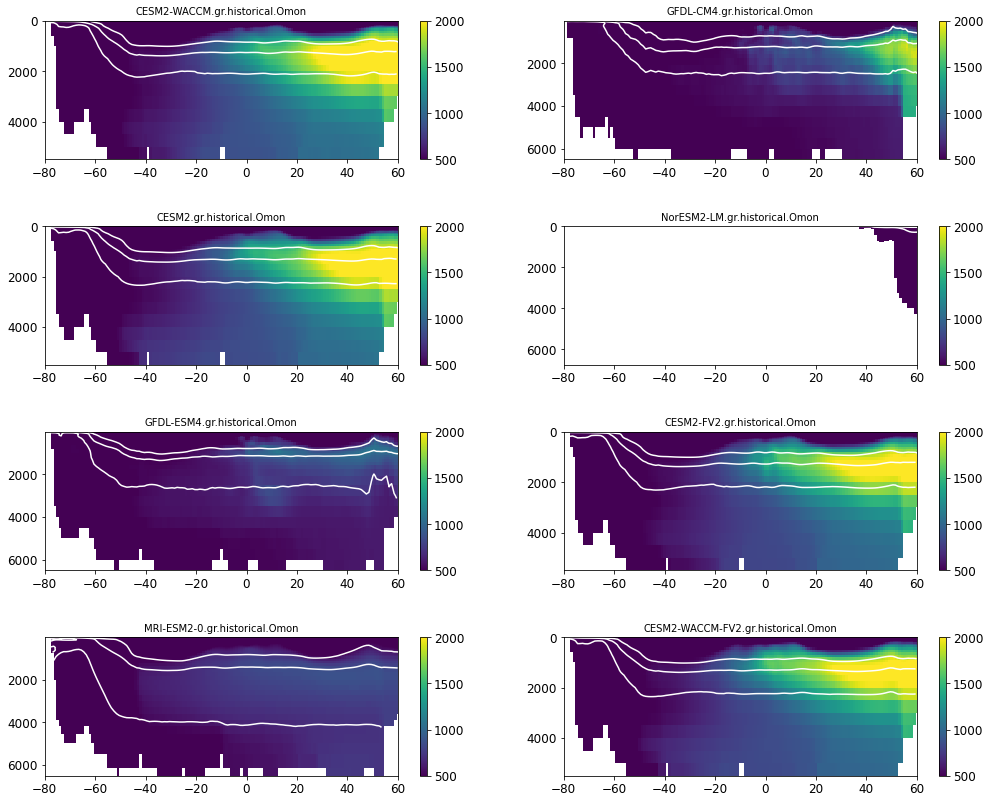

In [19]:
# fig, ax = plt.subplots(figsize=[10,3])
# ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
# if 'member_id' in ds.dims:
#     ds = ds.isel(member_id=0)
# pco2 = calc_PpCO2(ds)
# #sigma2 = calc_sigma2(ds)
# meridionalsection(ax,pco2,clims=[0,1000],title=ds.attrs['intake_esm_dataset_key'])

#You dont have to spell out all the axes, you can just keep them in an array
fig_pco2, axarr_pco2 = plt.subplots(nrows = 4, ncols = 2, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_new_new.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.isel(time=1200).sel(x=slice(180,200)).mean('x',keep_attrs=True)
#     if 'member_id' in ds_pco2.dims:
#         if name == 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr':
#             ds_pco2 = ds_pco2.isel(member_id=1)
#         elif name == 'CMIP.NCAR.CESM2.historical.Omon.gr':
#             ds_pco2 = ds_pco2.isel(member_id=2)
#         else:
#             ds_pco2 = ds_pco2.isel(member_id=0)
    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma2(ax,pco2,sigma2, clims=[500,2000],title=name)
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

# for name, ds_pco2 in dset_dict.items():
#     ds_pco2 = ds_pco2.isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
#     if 'member_id' in ds_pco2.dims:
#         if name == 'CMIP.NCAR.CESM2.historical.Omon.gr':
#             ds_pco2 = ds_pco2.isel(member_id=2)
#             pco2 = calc_PpCO2(ds_pco2)
#             print(pco2)



<xarray.DataArray 'talk' (member_id: 11, lev: 33, y: 180)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,       

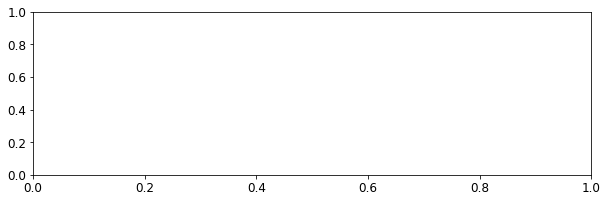

In [39]:
fig, ax = plt.subplots(figsize=[10,3])
ds = dset_dict['CMIP.NCAR.CESM2.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)
results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
print(ds['talk'].copy(data=results['pCO2_out']))
# if 'member_id' in ds.dims:
#     ds = ds.isel(member_id=0)
# pco2 = calc_PpCO2(ds)
# #sigma2 = calc_sigma2(ds)
# meridionalsection(ax,pco2,clims=[0,1000],title=ds.attrs['intake_esm_dataset_key'])

#### I'm not sure why pressure is only being calculated for the first depth and none of the others

In [10]:
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p

<xarray.DataArray 'lev' (lev: 35, y: 180)>
array([[2.52714941e+00, 2.52714125e+00, 2.52712495e+00, ...,
        2.52712495e+00, 2.52714125e+00, 2.52714941e+00],
       [1.01087837e+01, 1.01087511e+01, 1.01086859e+01, ...,
        1.01086859e+01, 1.01087511e+01, 1.01087837e+01],
       [2.02180635e+01, 2.02179983e+01, 2.02178679e+01, ...,
        2.02178679e+01, 2.02179983e+01, 2.02180635e+01],
       ...,
       [5.63244231e+03, 5.63242392e+03, 5.63238717e+03, ...,
        5.63238717e+03, 5.63242392e+03, 5.63244231e+03],
       [6.15144542e+03, 6.15142532e+03, 6.15138514e+03, ...,
        6.15138514e+03, 6.15142532e+03, 6.15144542e+03],
       [6.67156355e+03, 6.67154172e+03, 6.67149810e+03, ...,
        6.67149810e+03, 6.67154172e+03, 6.67156355e+03]])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    time     int64 0
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

#### Obvi this result is unreliable as long as p is wrong

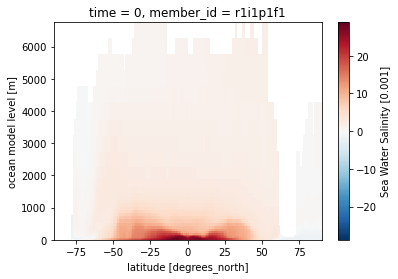

In [18]:
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)
insitutemp.plot()

In [17]:
dd_new_new['CESM2-FV2.gr.historical.Omon']

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 33, time: 1980, vertex: 4, x: 360, y: 180)
Coordinates: (12/14)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
  * lev            (lev) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    ...             ...
  * bnds           (bnds) int64 0 1
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(5, 33, 180, 360), meta=np.ndarray>
    so             (time, lev, y, x) float32 dask.array<chunksize=(5, 33, 180, 360), meta=np.ndarray>
    talk           (time, lev, y, x) float32 dask.array<chunksize=(5, 33, 180, 360), meta=np.ndarray>
    dissic         (time, lev, y, x) float32 dask.array<chunksize=(5, 33, 180, 360), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  10950.0
    case_id:                1559
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    variant_info:           CMIP6 CESM2-FV2 historical experiment (1850-2014)...
    variant_label:          r1i1p1f1
    version_id:             v20191120
    intake_esm_varname:     None

In [21]:
ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_new_new.items():
    ds_pco2 = ds_pco2.isel(time=1200, lev = 0)
#     if 'member_id' in ds_pco2.dims:
#         if name == 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr':
#             ds_pco2 = ds_pco2.isel(member_id=1)
#         elif name == 'CMIP.NCAR.CESM2.historical.Omon.gr':
#             ds_pco2 = ds_pco2.isel(member_id=2)
#         else:
#             ds_pco2 = ds_pco2.isel(member_id=0)
#     pco2 = calc_PpCO2(ds_pco2)
    print(ds_pco2)

<xarray.Dataset>
Dimensions:        (bnds: 2, vertex: 4, x: 360, y: 180)
Coordinates: (12/14)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
    lev            float64 0.0
    lev_bounds     (bnds) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    ...             ...
  * bnds           (bnds) int64 0 1
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
Data v

In [35]:
ds = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time=1200).sel(x=slice(180,200)).mean('x',keep_attrs=True)
out = calc_PpCO2(ds)
out

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'talk' (lev: 33, y: 180)>
array([[         nan,          nan,          nan, ..., 309.44352178,
        309.50128487, 309.3143347 ],
       [         nan,          nan,          nan, ..., 309.44460043,
        309.50219954, 309.31686714],
       [         nan,          nan,          nan, ..., 309.44678642,
        309.50517289, 309.31860388],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1950-01-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    total alkalinity equivalent concentration (including carb...
    frequency:      mon
    id:             talk
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Total Alkalinity
    type:           real
    units:          mol m-3
    variable_id:    talk

In [42]:
ds = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time=1200)
out = calc_PpCO2(ds)
out

PyCO2SYS error: input shapes cannot be broadcast together.


AttributeError: 'NoneType' object has no attribute 'keys'

In [46]:
ds = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time=1200)
ds['talk'].attrs

{'cell_measures': 'area: areacello volume: volcello',
 'cell_methods': 'area: mean where sea time: mean',
 'comment': 'Model data on the 1x1 grid includes values in all cells for which ocean cells on the native grid cover more than 52.5 percent of the 1x1 grid cell. This 52.5 percent cutoff was chosen to produce ocean surface area on the 1x1 grid as close as possible to ocean surface area on the native grid, while not introducing fractional cell coverage.',
 'description': 'total alkalinity equivalent concentration (including carbonate, borate, phosphorus, silicon, and nitrogen components)',
 'frequency': 'mon',
 'id': 'talk',
 'long_name': 'Total Alkalinity',
 'mipTable': 'Omon',
 'out_name': 'talk',
 'prov': 'Omon ((isd.003))',
 'realm': 'ocnBgchem',
 'standard_name': 'sea_water_alkalinity_expressed_as_mole_equivalent',
 'time': 'time',
 'time_label': 'time-mean',
 'time_title': 'Temporal mean',
 'title': 'Total Alkalinity',
 'type': 'real',
 'units': 'mol m-3',
 'variable_id': 'talk

In [40]:
dset_dict_old['CMIP.MRI.MRI-ESM2-0.historical.r1i2p1f1.Omon.thetao.gr.gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historical/r1i2p1f1/Omon/thetao/gr/v20200303/.nan.20200303'].attrs

{'Conventions': 'CF-1.7 CMIP-6.2',
 'activity_id': 'CMIP',
 'branch_method': 'standard',
 'branch_time_in_child': 0.0,
 'branch_time_in_parent': 0.0,
 'cmor_version': '3.5.0',
 'creation_date': '2020-02-12T04:06:02Z',
 'data_specs_version': '01.00.31',
 'experiment': 'all-forcing simulation of the recent past',
 'experiment_id': 'historical',
 'external_variables': 'areacello volcello',
 'forcing_index': 1,
 'frequency': 'mon',
 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.MRI.MRI-ESM2-0.historical.none.r1i2p1f1',
 'grid': 'data regridded to a CMIP6 standard 1x1 degree lonxlat grid from the native tri-polar grid using an area-average preserving method',
 'grid_label': 'gr',
 'history': '2020-02-12T04:06:02Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.',
 'initialization_index': 2,
 'institution': 'Meteorological Research Institute, Tsukuba, Ibaraki 305-0052, Japan',
 'institution_id': 'MRI',
 'license': 'CMIP6 model data produced by MR